In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt

## Učitavanje podataka

In [83]:
data = pd.read_csv('data.csv')

In [84]:
data.drop(columns=['Unnamed: 0'], inplace = True)

In [85]:
y = data.iloc[:, -1]
X = data.iloc[:, :data.shape[1] - 1]

### Pravljenje atributa i metrika za evaluaciju i izbor najboljeg modela

In [103]:
cnn_par_f = {
    'window': [3, 7, 11],
    'dropout': [0.2, 0.5]
}

In [87]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

In [88]:
filter_cnn = 64
num_classes = len(np.unique(y))
epochs = 25
K=10
pool = 3
classes = np.unique(y)

In [89]:
num_classes

5

In [90]:
scoring = {'f1_macro' : 'f1_macro', 'accuracy' : 'accuracy'}
for c in classes:
    def f1_class(y_true, y_pred, classes, c=c):
        return metrics.f1_score(y_true, y_pred, average=None)[c-1]
    scoring_name = 'f1_class_%d' % c
    scoring[scoring_name] = metrics.make_scorer(f1_class, classes = classes)

### Podela podataka na trening i testni skup, standardizacija i Furijeova transformacija

In [91]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, stratify = y,random_state = 1996)

In [92]:
from sklearn import preprocessing
scaler_train = preprocessing.StandardScaler()
scaler_train.fit(X_train)
X_train = scaler_train.transform(X_train)
X_test = scaler_train.transform(X_test)

In [93]:
print(X_train.shape, X_test.shape)

(8050, 178) (3450, 178)


In [94]:
X_train_fft = np.fft.rfft(X_train, axis=1).astype(float)
X_test_fft = np.fft.rfft(X_test, axis=1).astype(float)

C:\Users\vbakarevic\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.
C:\Users\vbakarevic\anaconda3\lib\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [95]:
print(X_train_fft.shape, X_test_fft.shape)

(8050, 90) (3450, 90)


In [96]:
X_train_fft = np.array(X_train_fft)
X_test_fft = np.array(X_test_fft)
X_train_fft = X_train_fft.reshape(X_train_fft.shape[0], X_train_fft.shape[1], 1)
X_test_fft = X_test_fft.reshape(X_test_fft.shape[0], X_test_fft.shape[1], 1)

In [97]:
print(X_train_fft.shape, X_test_fft.shape)

(8050, 90, 1) (3450, 90, 1)


## Pravljenje mreže i izbor najboljeg modela unakrsnom validacijom

In [98]:
input_shape = (X_train_fft.shape[1], 1)
input_shape

(90, 1)

In [99]:
from keras import optimizers

In [108]:
def mreza(input_shape, num_classes,window, dropout):
    model = Sequential()
    model.add(Conv1D(filter_cnn, window, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filter_cnn, window, activation='relu'))
    model.add(MaxPooling1D(pool))
    model.add(Conv1D(filter_cnn * 2, window, activation='relu'))
    model.add(Conv1D(filter_cnn * 2, window, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'])
    return model

In [109]:
from keras.wrappers.scikit_learn  import KerasClassifier
def get_estimator(window=3,dropout=0.5):
    return KerasClassifier(build_fn=mreza,input_shape=input_shape, num_classes=num_classes,window=window, dropout=dropout, epochs = epochs)

In [110]:
estimator = get_estimator()
grid_f_cnn = model_selection.GridSearchCV(estimator, param_grid=cnn_par_f, scoring=scoring, cv=K, refit='accuracy', return_train_score=True)

In [111]:
grid_f_cnn.fit(X_train_fft, y_train)

Epoch 1/25
7245/7245 [==============================] - 19s 3ms/step - loss: 1.0536 - accuracy: 0.5365
Epoch 2/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.9057 - accuracy: 0.5935
Epoch 3/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.8534 - accuracy: 0.6218
Epoch 4/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.8346 - accuracy: 0.6277
Epoch 5/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.8316 - accuracy: 0.6275
Epoch 6/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.8219 - accuracy: 0.6297
Epoch 7/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.8092 - accuracy: 0.6330
Epoch 8/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7966 - accuracy: 0.6367
Epoch 9/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7999 - accuracy: 0.6380
Epoch 10/25
7245/7245 [==============================] - 15s 2ms/step - l

Epoch 5/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.8294 - accuracy: 0.6242
Epoch 6/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.8191 - accuracy: 0.6228
Epoch 7/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.8200 - accuracy: 0.6287
Epoch 8/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7971 - accuracy: 0.6346
Epoch 9/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.8013 - accuracy: 0.6386
Epoch 10/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7920 - accuracy: 0.6377
Epoch 11/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7883 - accuracy: 0.6440
Epoch 12/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7748 - accuracy: 0.6449
Epoch 13/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.7824 - accuracy: 0.6431
Epoch 14/25
7245/7245 [==============================] - 15s 2ms/step

7245/7245 [==============================] - 16s 2ms/step - loss: 0.7893 - accuracy: 0.6449
Epoch 10/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7875 - accuracy: 0.6457
Epoch 11/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7717 - accuracy: 0.6471
Epoch 12/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7813 - accuracy: 0.6431
Epoch 13/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7592 - accuracy: 0.6497
Epoch 14/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7698 - accuracy: 0.6513
Epoch 15/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7721 - accuracy: 0.6479
Epoch 16/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7683 - accuracy: 0.6505
Epoch 17/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7786 - accuracy: 0.6542
Epoch 18/25
7245/7245 [==============================] - 16s 2ms/step - loss

7245/7245 [==============================] - 16s 2ms/step - loss: 0.7316 - accuracy: 0.6663
Epoch 14/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7356 - accuracy: 0.6638
Epoch 15/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7243 - accuracy: 0.6756
Epoch 16/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7179 - accuracy: 0.6820
Epoch 17/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7016 - accuracy: 0.6810
Epoch 18/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.6918 - accuracy: 0.6854
Epoch 19/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.6843 - accuracy: 0.6894
Epoch 20/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.6764 - accuracy: 0.6948
Epoch 21/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.6872 - accuracy: 0.6918
Epoch 22/25
7245/7245 [==============================] - 16s 2ms/step - loss

7245/7245 [==============================] - 17s 2ms/step - loss: 0.7459 - accuracy: 0.6705
Epoch 18/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7368 - accuracy: 0.6674
Epoch 19/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7452 - accuracy: 0.6656
Epoch 20/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7703 - accuracy: 0.6562
Epoch 21/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7822 - accuracy: 0.6533
Epoch 22/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7830 - accuracy: 0.6489
Epoch 23/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7402 - accuracy: 0.6700
Epoch 24/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7605 - accuracy: 0.6636
Epoch 25/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7397 - accuracy: 0.6634
Epoch 1/25
7245/7245 [==============================] - 21s 3ms/step - loss:

7245/7245 [==============================] - 17s 2ms/step - loss: 0.6041 - accuracy: 0.7252
Epoch 22/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.6028 - accuracy: 0.7245
Epoch 23/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.6074 - accuracy: 0.7208
Epoch 24/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.5941 - accuracy: 0.7288
Epoch 25/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.6256 - accuracy: 0.7222
Epoch 1/25
7245/7245 [==============================] - 21s 3ms/step - loss: 1.0816 - accuracy: 0.5278
Epoch 2/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7925 - accuracy: 0.6473
Epoch 3/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7813 - accuracy: 0.6450
Epoch 4/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7574 - accuracy: 0.6542
Epoch 5/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7

7245/7245 [==============================] - 18s 2ms/step - loss: 0.6338 - accuracy: 0.7059
Epoch 1/25
7245/7245 [==============================] - 21s 3ms/step - loss: 1.4116 - accuracy: 0.3771
Epoch 2/25
7245/7245 [==============================] - 17s 2ms/step - loss: 1.1966 - accuracy: 0.4578
Epoch 3/25
7245/7245 [==============================] - 17s 2ms/step - loss: 1.1516 - accuracy: 0.4803
Epoch 4/25
7245/7245 [==============================] - 17s 2ms/step - loss: 1.1102 - accuracy: 0.5108
Epoch 5/25
7245/7245 [==============================] - 17s 2ms/step - loss: 1.1012 - accuracy: 0.5060
Epoch 6/25
7245/7245 [==============================] - 17s 2ms/step - loss: 1.1001 - accuracy: 0.5063
Epoch 7/25
7245/7245 [==============================] - 17s 2ms/step - loss: 1.0546 - accuracy: 0.5366
Epoch 8/25
7245/7245 [==============================] - 17s 2ms/step - loss: 1.0537 - accuracy: 0.5357
Epoch 9/25
7245/7245 [==============================] - 17s 2ms/step - loss: 1.0504 

7245/7245 [==============================] - 18s 3ms/step - loss: 0.6924 - accuracy: 0.6745
Epoch 5/25
7245/7245 [==============================] - 18s 3ms/step - loss: 0.7099 - accuracy: 0.6698
Epoch 6/25
7245/7245 [==============================] - 18s 3ms/step - loss: 0.6456 - accuracy: 0.6939
Epoch 7/25
7245/7245 [==============================] - 18s 3ms/step - loss: 0.6419 - accuracy: 0.6977
Epoch 8/25
7245/7245 [==============================] - 18s 3ms/step - loss: 0.6506 - accuracy: 0.6945
Epoch 9/25
7245/7245 [==============================] - 18s 3ms/step - loss: 0.6197 - accuracy: 0.7071
Epoch 10/25
7245/7245 [==============================] - 18s 3ms/step - loss: 0.6006 - accuracy: 0.7281
Epoch 11/25
7245/7245 [==============================] - 18s 3ms/step - loss: 0.6589 - accuracy: 0.7021
Epoch 12/25
7245/7245 [==============================] - 18s 3ms/step - loss: 0.6361 - accuracy: 0.7101
Epoch 13/25
7245/7245 [==============================] - 18s 3ms/step - loss: 0.6

7245/7245 [==============================] - 19s 3ms/step - loss: 0.6491 - accuracy: 0.7049
Epoch 9/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.6420 - accuracy: 0.7039
Epoch 10/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.6243 - accuracy: 0.7100
Epoch 11/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.6208 - accuracy: 0.7148
Epoch 12/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.6101 - accuracy: 0.7151
Epoch 13/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.6043 - accuracy: 0.7231
Epoch 14/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.6006 - accuracy: 0.7231
Epoch 15/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.6250 - accuracy: 0.7206
Epoch 16/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.6084 - accuracy: 0.7263
Epoch 17/25
7245/7245 [==============================] - 19s 3ms/step - loss:

7245/7245 [==============================] - 20s 3ms/step - loss: 0.6276 - accuracy: 0.7066
Epoch 12/25
7245/7245 [==============================] - 20s 3ms/step - loss: 0.7082 - accuracy: 0.6741
Epoch 13/25
7245/7245 [==============================] - 20s 3ms/step - loss: 0.6359 - accuracy: 0.7035
Epoch 14/25
7245/7245 [==============================] - 20s 3ms/step - loss: 0.6321 - accuracy: 0.7020
Epoch 15/25
7245/7245 [==============================] - 20s 3ms/step - loss: 0.6196 - accuracy: 0.7146
Epoch 16/25
7245/7245 [==============================] - 20s 3ms/step - loss: 0.5958 - accuracy: 0.7242
Epoch 17/25
7245/7245 [==============================] - 20s 3ms/step - loss: 0.6426 - accuracy: 0.7079
Epoch 18/25
7245/7245 [==============================] - 20s 3ms/step - loss: 0.6448 - accuracy: 0.7012
Epoch 19/25
7245/7245 [==============================] - 20s 3ms/step - loss: 0.6352 - accuracy: 0.7108
Epoch 20/25
7245/7245 [==============================] - 20s 3ms/step - loss

7245/7245 [==============================] - 18s 2ms/step - loss: 0.8273 - accuracy: 0.6366
Epoch 16/25
7245/7245 [==============================] - 18s 2ms/step - loss: 0.8172 - accuracy: 0.6288
Epoch 17/25
7245/7245 [==============================] - 18s 2ms/step - loss: 0.8265 - accuracy: 0.6380
Epoch 18/25
7245/7245 [==============================] - 18s 2ms/step - loss: 0.8129 - accuracy: 0.6298
Epoch 19/25
7245/7245 [==============================] - 18s 2ms/step - loss: 0.8228 - accuracy: 0.6313
Epoch 20/25
7245/7245 [==============================] - 18s 2ms/step - loss: 0.7932 - accuracy: 0.6443
Epoch 21/25
7245/7245 [==============================] - 18s 2ms/step - loss: 0.8160 - accuracy: 0.6352
Epoch 22/25
7245/7245 [==============================] - 18s 2ms/step - loss: 0.8182 - accuracy: 0.6342
Epoch 23/25
7245/7245 [==============================] - 18s 2ms/step - loss: 0.7977 - accuracy: 0.6384
Epoch 24/25
7245/7245 [==============================] - 18s 2ms/step - loss

7245/7245 [==============================] - 19s 3ms/step - loss: 0.8029 - accuracy: 0.6334
Epoch 20/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.8142 - accuracy: 0.6349
Epoch 21/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.8107 - accuracy: 0.6340
Epoch 22/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.8114 - accuracy: 0.6348
Epoch 23/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.7982 - accuracy: 0.6417
Epoch 24/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.8170 - accuracy: 0.6388
Epoch 25/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.8084 - accuracy: 0.6382
Epoch 1/25
7245/7245 [==============================] - 23s 3ms/step - loss: 1.1238 - accuracy: 0.4981
Epoch 2/25
7245/7245 [==============================] - 18s 3ms/step - loss: 0.9409 - accuracy: 0.5902
Epoch 3/25
7245/7245 [==============================] - 18s 3ms/step - loss: 0

7245/7245 [==============================] - 18s 3ms/step - loss: 0.8014 - accuracy: 0.6420
Epoch 24/25
7245/7245 [==============================] - 18s 3ms/step - loss: 0.7902 - accuracy: 0.6472
Epoch 25/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.7986 - accuracy: 0.6461
Epoch 1/25
7245/7245 [==============================] - 24s 3ms/step - loss: 1.1304 - accuracy: 0.4933
Epoch 2/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.9626 - accuracy: 0.5841
Epoch 3/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.9159 - accuracy: 0.6004
Epoch 4/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.8896 - accuracy: 0.6077
Epoch 5/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.8941 - accuracy: 0.6072
Epoch 6/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.8734 - accuracy: 0.6066
Epoch 7/25
7245/7245 [==============================] - 19s 3ms/step - loss: 0.872

7245/7245 [==============================] - 21s 3ms/step - loss: 0.8956 - accuracy: 0.6010A: 17s - loss: 0.8848 - accura - ETA: 16s - loss: 0.8944 - ac - ETA: 15s - loss: 0.9077 - accuracy: 0. - ETA: 14s - loss: 0.9099 - accuracy:
Epoch 17/25
7245/7245 [==============================] - 21s 3ms/step - loss: 0.8590 - accuracy: 0.6246A: 12s - loss - ETA: 6s - loss: 0.8569 - accu - ETA: 3s - - ETA: 2s - loss: 0.8519 - accuracy - ETA
Epoch 18/25
7245/7245 [==============================] - 21s 3ms/step - loss: 0.8504 - accuracy: 0.6200A - ETA: 6s - loss: 0.8 - - ETA: 3s - loss: 0.8421 -  - ETA: 1s - loss: 0.8471 - accura - ETA: 0s - loss: 0.8495 - 
Epoch 19/25
7245/7245 [==============================] - 21s 3ms/step - loss: 0.8443 - accuracy: 0.6243
Epoch 20/25
7245/7245 [==============================] - 21s 3ms/step - loss: 0.8668 - accuracy: 0.6047 
Epoch 21/25
7245/7245 [==============================] - 21s 3ms/step - loss: 0.8682 - accuracy: 0.6157
Epoch 22/25
7245/7245 [==========

7245/7245 [==============================] - 20s 3ms/step - loss: 1.1599 - accuracy: 0.4756A: 14s  - ETA: 2s - loss: 1.1578 - ac - ETA - ETA: 0s - loss: 1.1569 - accu
Epoch 3/25
7245/7245 [==============================] - 20s 3ms/step - loss: 1.1161 - accuracy: 0.5053 1s - loss: 1.1175 - ac - ETA: 0s - loss: 1.1195 - accuracy - ETA: 0s - loss: 1.1173 - accuracy
Epoch 4/25
7245/7245 [==============================] - 20s 3ms/step - loss: 1.0354 - accuracy: 0.5429 1s - loss: 1.0381 - accuracy:  - ETA: 0s - loss: 1.0366 
Epoch 5/25
7245/7245 [==============================] - 20s 3ms/step - loss: 1.0075 - accuracy: 0.5553
Epoch 6/25
7245/7245 [==============================] - 21s 3ms/step - loss: 1.0219 - accuracy: 0.5509 0s - loss: 1.0223 - 
Epoch 7/25
7245/7245 [==============================] - 21s 3ms/step - loss: 1.0044 - accuracy: 0.5651A: 2s - loss: 1.0106 - accuracy - ETA: 1s - loss: 1.0082 - accuracy:  - ETA: 1s - loss: 1.0086 -  - ETA: 0s - loss: 1.0049 
Epoch 8/25
7245/7245 [

7245/7245 [==============================] - 21s 3ms/step - loss: 0.6760 - accuracy: 0.6969A: 19s - loss: 0.6115 - accuracy: 0.726 - ETA: 19s - loss: 0.6086 - accuracy: 0.72 - ETA:  - ETA: 15s - loss: 0. - ETA: 1s - loss: 0.6726 - accuracy: 0.69 - ETA: 1s - los
Epoch 14/25
7245/7245 [==============================] - 21s 3ms/step - loss: 0.7126 - accuracy: 0.6841
Epoch 15/25
7245/7245 [==============================] - 21s 3ms/step - loss: 0.6989 - accuracy: 0.6846
Epoch 16/25
7245/7245 [==============================] - 21s 3ms/step - loss: 0.6795 - accuracy: 0.6838 3s -
Epoch 17/25
7245/7245 [==============================] - 21s 3ms/step - loss: 0.6707 - accuracy: 0.6904
Epoch 18/25
7245/7245 [==============================] - 21s 3ms/step - loss: 0.7161 - accuracy: 0.6784 1s - l
Epoch 19/25
7245/7245 [==============================] - 21s 3ms/step - loss: 0.7488 - accuracy: 0.6762 0s - loss: 0.7488 - accuracy: 0.67 - ETA: 0s - loss: 0.7505 - accura
Epoch 20/25
7245/7245 [==========

7245/7245 [==============================] - 21s 3ms/step - loss: 1.0784 - accuracy: 0.5303
Epoch 6/25
7245/7245 [==============================] - 21s 3ms/step - loss: 1.0726 - accuracy: 0.5313
Epoch 7/25
7245/7245 [==============================] - 21s 3ms/step - loss: 1.0583 - accuracy: 0.5395A: 18s - loss: 1.0437 - accuracy:  - ETA: 17s - loss: 1.0 - ETA: 15s - loss: 1.0534 - accura - ETA: 14s  - ETA: 11s - loss: 1.0538 - accuracy - ETA: 11s - loss: 1.0476 - accuracy - ETA: 10s - loss - ETA: 8s - ETA: 7s - l
Epoch 8/25
7245/7245 [==============================] - 21s 3ms/step - loss: 1.0761 - accuracy: 0.5329A: 1 - ETA: 16s - loss:  - ET - ETA: 10s - loss: 1.0843 - accuracy: 
Epoch 9/25
7245/7245 [==============================] - 21s 3ms/step - loss: 1.0476 - accuracy: 0.5429 0s - loss: 1.0469 - accuracy
Epoch 10/25
7245/7245 [==============================] - 21s 3ms/step - loss: 1.0390 - accuracy: 0.5426- ETA: 5s - loss: 1.0257 - accu - E - ETA: 2s - loss: 1.0
Epoch 11/25
7245/7

7245/7245 [==============================] - 22s 3ms/step - loss: 0.6695 - accuracy: 0.6867
Epoch 1/25
7245/7245 [==============================] - 30s 4ms/step - loss: 1.3538 - accuracy: 0.4025
Epoch 2/25
7245/7245 [==============================] - 24s 3ms/step - loss: 1.1382 - accuracy: 0.4954
Epoch 3/25
7245/7245 [==============================] - 23s 3ms/step - loss: 1.0880 - accuracy: 0.5078
Epoch 4/25
7245/7245 [==============================] - 23s 3ms/step - loss: 1.0951 - accuracy: 0.5197
Epoch 5/25
7245/7245 [==============================] - 23s 3ms/step - loss: 1.0466 - accuracy: 0.5303
Epoch 6/25
7245/7245 [==============================] - 23s 3ms/step - loss: 1.0215 - accuracy: 0.5387
Epoch 7/25
7245/7245 [==============================] - 23s 3ms/step - loss: 1.0029 - accuracy: 0.5553
Epoch 8/25
7245/7245 [==============================] - 23s 3ms/step - loss: 0.9824 - accuracy: 0.5602
Epoch 9/25
7245/7245 [==============================] - ETA: 0s - loss: 1.0250 - acc

Epoch 3/25
7245/7245 [==============================] - 24s 3ms/step - loss: 0.7666 - accuracy: 0.6479
Epoch 4/25
7245/7245 [==============================] - 24s 3ms/step - loss: 0.7962 - accuracy: 0.6458
Epoch 5/25
7245/7245 [==============================] - 24s 3ms/step - loss: 0.7550 - accuracy: 0.6589
Epoch 6/25
7245/7245 [==============================] - 24s 3ms/step - loss: 0.7366 - accuracy: 0.6585
Epoch 7/25
7245/7245 [==============================] - 24s 3ms/step - loss: 0.7322 - accuracy: 0.6657
Epoch 8/25
7245/7245 [==============================] - 24s 3ms/step - loss: 0.7586 - accuracy: 0.6556
Epoch 9/25
7245/7245 [==============================] - 24s 3ms/step - loss: 0.7151 - accuracy: 0.6780
Epoch 10/25
7245/7245 [==============================] - 24s 3ms/step - loss: 0.7434 - accuracy: 0.6634
Epoch 11/25
7245/7245 [==============================] - 24s 3ms/step - loss: 0.7864 - accuracy: 0.6540
Epoch 12/25
7245/7245 [==============================] - 24s 3ms/step -

7245/7245 [==============================] - 23s 3ms/step - loss: 1.0257 - accuracy: 0.5393
Epoch 8/25
7245/7245 [==============================] - 23s 3ms/step - loss: 1.0292 - accuracy: 0.5332
Epoch 9/25
7245/7245 [==============================] - 23s 3ms/step - loss: 0.9874 - accuracy: 0.5542
Epoch 10/25
7245/7245 [==============================] - 23s 3ms/step - loss: 0.9802 - accuracy: 0.5586
Epoch 11/25
7245/7245 [==============================] - 23s 3ms/step - loss: 0.9749 - accuracy: 0.5568
Epoch 12/25
7245/7245 [==============================] - 23s 3ms/step - loss: 0.9774 - accuracy: 0.5660
Epoch 13/25
7245/7245 [==============================] - 23s 3ms/step - loss: 1.0212 - accuracy: 0.5477
Epoch 14/25
7245/7245 [==============================] - 23s 3ms/step - loss: 1.0025 - accuracy: 0.5596
Epoch 15/25
7245/7245 [==============================] - 23s 3ms/step - loss: 0.9770 - accuracy: 0.5527
Epoch 16/25
7245/7245 [==============================] - 23s 3ms/step - loss: 

8050/8050 [==============================] - 26s 3ms/step - loss: 0.9863 - accuracy: 0.5598
Epoch 12/25
8050/8050 [==============================] - 26s 3ms/step - loss: 0.9271 - accuracy: 0.5790
Epoch 13/25
8050/8050 [==============================] - 26s 3ms/step - loss: 0.9254 - accuracy: 0.5842
Epoch 14/25
8050/8050 [==============================] - 26s 3ms/step - loss: 0.9095 - accuracy: 0.5889
Epoch 15/25
8050/8050 [==============================] - 26s 3ms/step - loss: 0.9087 - accuracy: 0.5862
Epoch 16/25
8050/8050 [==============================] - 26s 3ms/step - loss: 0.8901 - accuracy: 0.5988
Epoch 17/25
8050/8050 [==============================] - 26s 3ms/step - loss: 0.9034 - accuracy: 0.5934
Epoch 18/25
8050/8050 [==============================] - 26s 3ms/step - loss: 0.9460 - accuracy: 0.5812
Epoch 19/25
8050/8050 [==============================] - 26s 3ms/step - loss: 0.9187 - accuracy: 0.5876
Epoch 20/25
8050/8050 [==============================] - 26s 3ms/step - loss

GridSearchCV(cv=10, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000023DC9A30710>,
             iid='deprecated', n_jobs=None,
             param_grid={'dropout': [0.2, 0.5], 'window': [3, 7, 11]},
             pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'f1_class_1': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_class_2': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_class_3': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_class_4': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_class_5': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_macro': 'f1_macro'},
             verbose=0)

In [112]:
grid_f_cnn.best_params_

{'dropout': 0.2, 'window': 11}

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


In [114]:
grid_f_cnn.best_score_

0.6859627329192546

### Rezultati unakrsne validacije

In [115]:
grid_f_cnn_results =pd.DataFrame(grid_f_cnn.cv_results_)
print(grid_f_cnn_results)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_dropout  \
0     427.236405      6.681003        12.874672        0.367321           0.2   
1     470.087049      9.366352        14.174152        0.344505           0.2   
2     521.913036     15.009194        15.446432        0.435906           0.2   
3     516.548733     12.665839        16.984404        0.519983           0.5   
4     587.874783     15.759785        18.596172        0.547678           0.5   
5     649.444603     12.358296        19.938748        0.420554           0.5   

  param_window                          params  split0_test_f1_macro  \
0            3   {'dropout': 0.2, 'window': 3}              0.629120   
1            7   {'dropout': 0.2, 'window': 7}              0.599237   
2           11  {'dropout': 0.2, 'window': 11}              0.623702   
3            3   {'dropout': 0.5, 'window': 3}              0.679540   
4            7   {'dropout': 0.5, 'window': 7}              0.635094   


In [116]:
grid_f_cnn_results.to_csv('grid_f_cnn_with_reg_scoring_results.csv')

In [117]:
grid_f_cnn_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout,param_window,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,...,split2_train_f1_class_5,split3_train_f1_class_5,split4_train_f1_class_5,split5_train_f1_class_5,split6_train_f1_class_5,split7_train_f1_class_5,split8_train_f1_class_5,split9_train_f1_class_5,mean_train_f1_class_5,std_train_f1_class_5
0,427.236405,6.681003,12.874672,0.367321,0.2,3,"{'dropout': 0.2, 'window': 3}",0.629120,0.648544,0.673654,...,0.704437,0.702474,0.708261,0.737535,0.681001,0.673520,0.723566,0.754414,0.696271,0.045498
1,470.087049,9.366352,14.174152,0.344505,0.2,7,"{'dropout': 0.2, 'window': 7}",0.599237,0.666825,0.640063,...,0.707953,0.704027,0.727218,0.745514,0.748323,0.792428,0.758945,0.698811,0.725987,0.032855
2,521.913036,15.009194,15.446432,0.435906,0.2,11,"{'dropout': 0.2, 'window': 11}",0.623702,0.706983,0.686944,...,0.800414,0.796875,0.813388,0.785955,0.799640,0.800998,0.776228,0.588204,0.759843,0.074249
3,516.548733,12.665839,16.984404,0.519983,0.5,3,"{'dropout': 0.5, 'window': 3}",0.679540,0.650691,0.647622,...,0.709394,0.668594,0.704158,0.656457,0.680139,0.699938,0.692198,0.706377,0.688020,0.019340
4,587.874783,15.759785,18.596172,0.547678,0.5,7,"{'dropout': 0.5, 'window': 7}",0.635094,0.616343,0.678624,...,0.732705,0.643995,0.753643,0.779066,0.713580,0.514643,0.489419,0.663028,0.651897,0.094929


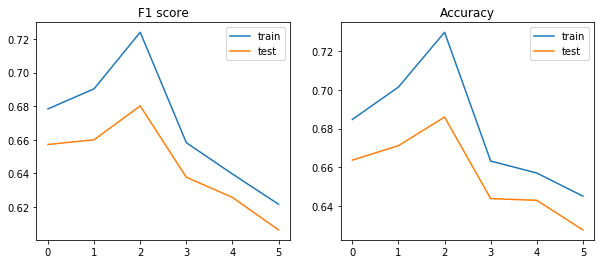

In [118]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('F1 score')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_train_f1_macro'], label='train')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_test_f1_macro'], label='test')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_train_accuracy'], label='train')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_test_accuracy'], label='test')
plt.legend(loc='best')

## Čuvanje i evaluacija najboljeg modela

In [119]:
best_model = grid_f_cnn.best_estimator_

In [121]:
import joblib
joblib.dump(best_model, 'cnn_fft_with_reg.joblib')

['cnn_fft_with_reg.joblib']

In [122]:
y_pred = grid_f_cnn.predict(X_test_fft)

In [123]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.86      0.88      0.87       690
           2       0.48      0.56      0.52       690
           3       0.61      0.27      0.37       690
           4       0.89      0.34      0.49       690
           5       0.42      0.83      0.56       690

    accuracy                           0.58      3450
   macro avg       0.65      0.58      0.56      3450
weighted avg       0.65      0.58      0.56      3450



In [124]:
print(metrics.classification_report(y_test, y_pred, output_dict=True))

{'1': {'precision': 0.8553370786516854, 'recall': 0.8826086956521739, 'f1-score': 0.8687589158345221, 'support': 690}, '2': {'precision': 0.485, 'recall': 0.5623188405797102, 'f1-score': 0.5208053691275168, 'support': 690}, '3': {'precision': 0.6052631578947368, 'recall': 0.26666666666666666, 'f1-score': 0.3702213279678068, 'support': 690}, '4': {'precision': 0.8872180451127819, 'recall': 0.34202898550724636, 'f1-score': 0.49372384937238495, 'support': 690}, '5': {'precision': 0.42105263157894735, 'recall': 0.8347826086956521, 'f1-score': 0.5597667638483964, 'support': 690}, 'accuracy': 0.5776811594202899, 'macro avg': {'precision': 0.6507741826476303, 'recall': 0.5776811594202899, 'f1-score': 0.5626552452301253, 'support': 3450}, 'weighted avg': {'precision': 0.6507741826476304, 'recall': 0.5776811594202899, 'f1-score': 0.5626552452301254, 'support': 3450}}


In [125]:
print('Accuracy na testnom skupu je ', metrics.classification_report(y_test, y_pred, output_dict=True)['accuracy'])

Accuracy na testnom skupu je  0.5776811594202899


In [126]:
print('F1 score na testnom skupu je ', metrics.classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score'])

F1 score na testnom skupu je  0.5626552452301253


In [127]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[609   0   8   7  66]
 [ 39 388  72  10 181]
 [ 17 364 184   1 124]
 [ 26   6   1 236 421]
 [ 21  42  39  12 576]]


(5.5, -0.5)

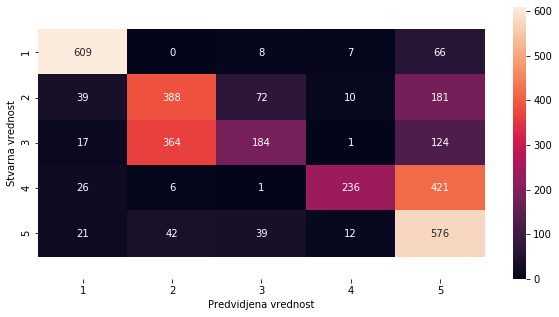

In [128]:
import seaborn
df_cm = pd.DataFrame(cm, index = classes, columns=classes)
plt.figure(figsize = (10, 5))
ax = seaborn.heatmap(df_cm, annot=True, fmt="d")
ax.set_ylabel('Stvarna vrednost')
ax.set_xlabel('Predvidjena vrednost')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)